# Analyze A/B Test Results 
 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be analyzing the results of an A/B test conducted by an e-commerce website using a dummy dataset provided by Udacity in the form of a CSV file.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)


<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

In [4]:
df['user_id'].nunique()

290584

#### The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

#### The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

#### Do any of the rows have missing values?

In [6]:
(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].shape[0])  

1965

In [7]:
(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0])

1928

In [8]:
# number of times when the "group" is treatment but "landing_page" is not a new_page
cols_not_matching = 1928 + 1965
cols_not_matching

3893

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

I will remove the inaccurate rows and store the result as df2.

In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
tx_old_page = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index
tx_old_page

Int64Index([   308,    327,    357,    685,    713,    776,    889,   1037,
              1106,   1376,
            ...
            293240, 293302, 293391, 293443, 293530, 293773, 293817, 293917,
            294014, 294252],
           dtype='int64', length=1965)

In [11]:
df.drop(tx_old_page, inplace = True)

In [12]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [13]:
# getting the index of the mismatching rows
con_new_page = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index
con_new_page

Int64Index([    22,    240,    490,    846,    850,    988,   1198,   1354,
              1474,   1877,
            ...
            293393, 293480, 293568, 293662, 293888, 293894, 293996, 294200,
            294253, 294331],
           dtype='int64', length=1928)

In [14]:
df.drop(con_new_page, inplace = True)

In [15]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [16]:
df2 = df
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [17]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** The number of unique **user_id**s in **df2**.

In [18]:
df2['user_id'].nunique()

290584

**b.** The repeated **user_id** in **df2**.  

In [19]:
duplicate_rows = df2[df2.duplicated(['user_id'])]

**c.** The rows for the duplicate **user_id**. 

In [20]:
#source- https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

user_id = df2["user_id"]
df[user_id.isin(user_id[user_id.duplicated()])].sort_values("user_id")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Removing **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [21]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
user_id_duplicate = df2[df2.duplicated(['user_id'])].index
df2.drop(user_id_duplicate, inplace = True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(['user_id'])].sum()

user_id         0.0
timestamp       0.0
group           0.0
landing_page    0.0
converted       0.0
dtype: float64

### ToDo 1.4  

**a.** The probability of an individual converting regardless of the page they receive on the website.<br><br>



In [22]:
p_population = df2['converted'].mean()
p_population 

0.11959708724499628

**b.** Given that an individual was in the `control` group, The probability they converted is:

In [23]:
con_obs = df.groupby('group').converted.mean()
con_obs = con_obs['control']
con_obs

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, The probability they converted is:

In [24]:
treat_obs = df.groupby('group').converted.mean()
treat_obs = treat_obs['treatment']
treat_obs

0.11880806551510564

In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff = treat_obs - con_obs
obs_diff

-0.0015782389853555567

**d.** The probability that an individual received the new page is:

In [26]:
p_new_page = pd.get_dummies(df['landing_page'])
p_new_page['new_page'].mean()

0.50006194422266881

#### Did the new `treatment` group users lead to more conversions?

The conversion rate for the users in the control group was about .1% higher than the users in the treatment group. So the users in the treatment group did not lead to more conversations. I recommend to run the experiment for a longer period of time and establish a significance level for a statistical analysis. 

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

 

Hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

### Null Hypothesis (𝐻0): 𝑝𝑜𝑙𝑑 = 𝑝𝑛𝑒𝑤
### Alternative Hypothesis (𝐻1): 𝑝𝑜𝑙𝑑 > 𝑝𝑛𝑒𝑤

 Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

#### The null hypothesis is that 𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  are equal.

In [27]:
p_new = p_population 

#### The **conversion rate** for $p_{old}$ under the null hypothesis is:

In [28]:
p_old = p_population 

#### What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [29]:
# filter and get treatment group only 
treatment_df = df2[df2.group > 'control']
treat_users = treatment_df['user_id'].count()
n_new = treat_users
n_new

145310

#### What is $n_{old}$, the number of individuals in the control group?

In [30]:
control_df = df2[df2.group == 'control']
control_users = control_df['user_id']
n_old = control_users.count()

#### Simulating Sample for the `treatment` Group<br> 
Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [31]:
treat_conv = treatment_df['converted']
treat_conv.head()

2    0
3    0
6    1
8    1
9    1
Name: converted, dtype: int64

In [32]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(treat_conv, size = treat_conv.shape[0] , replace= True)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

#### Simulating Sample for the `control` Group <br>
Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [33]:
cont_conv = control_df['converted']
cont_conv.head()

0    0
1    0
4    1
5    0
7    0
Name: converted, dtype: int64

In [34]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(cont_conv, size = cont_conv.shape[0], replace=True)
old_page_converted

array([1, 1, 0, ..., 0, 0, 0])

Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [35]:
conv_treat = new_page_converted.mean()
conv_treat

0.11822310921478218

In [36]:
conv_cont = old_page_converted.mean()
conv_cont

0.11987692222971763

In [37]:
p_converted = conv_treat - conv_cont
p_converted

-0.0016538130149354457


Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process previously. 

<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [38]:
# Sampling distribution 
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

p_diffs

array([ -1.28201636e-03,   8.10384959e-04,  -4.35940430e-05, ...,
        -3.60046074e-04,  -3.11772586e-04,   7.68682932e-04])


#### Ploting a histogram of the **p_diffs**.   


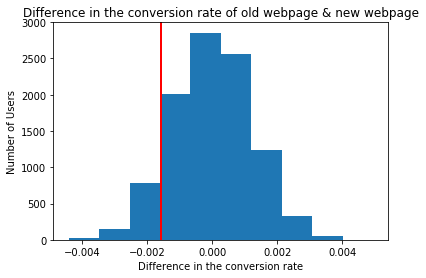

In [39]:
plt.hist(p_diffs);
plt.xlabel('Difference in the conversion rate')
plt.ylabel('Number of Users')
plt.title('Difference in the conversion rate of old webpage & new webpage')
plt.axvline(x = obs_diff, color = 'r', linewidth = 2);

#### The proportion of the **p_diffs** that are greater than the actual difference observed in the `df2` data.

In [40]:
p_value = (p_diffs > obs_diff).mean()
p_value


0.90110000000000001

This value is the p-value, which is the chance of observing the test statistic or extreme values favoring the alternative hypothesis given the null is true. 

Given the type 1 erorr rate (0.05), the p-value is higher than the false positive rate (alternative is chosen but the null is true). In this case, we fail to reject the null hypothesis.  

#### Hypothesis testing :

- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [41]:
# number of conversions with the old_page
convert_old = sum(df2.query("group == 'control'")['converted'])

# number of conversions with the new_page
convert_new = sum(df2.query("group == 'treatment'")['converted'])

# number of individuals who were shown the old_page
n_old = len(old_page_converted)

# number of individuals who received new_page
n_new = len(new_page_converted)

In [42]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count = (convert_old, convert_new)
nobs = len(old_page_converted) + len(new_page_converted)
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative = 'smaller')
print(z_score, p_value)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


1.24473215322 0.8933848886


This is a left tailed test, meaning the alternative hypothesis is pnew < pold and the calculation of z-score is 0.00412 and 0.00412 is greater than Z0.05 (-1.64) for a 95% confidence interval. This means that the test statistic does not fall under the rejection region and we fail to reject the null hypothesis. By failing to reject the null hypothesis, we conclude that the conversion rate of users visiting the new webpage is equal to the conversion rate of users visiting the old webpage. 

And the p-value of 0.90 is greater than the significant level of 0.05 so we fail to reject the null. The p-value is not similar to the one computed earlier, the one computed earlier was 0.1 but was also greater than the significance level of 0.05. 

With the z-score, we fail to reject the null hypothesis and conclude that there was is no difference in the two population proportions (control and treatment group).

With the p-value, we fail to reject the null hypothesis and conclude that the performance of the conversion of the users with the new webpage was equal to the conversion of the users with the old webpage. 

<a id='regression'></a>
### Part III - A regression approach

The result I achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

The type of regression to use is logistic regression because the question is on the conversion of a user, where the response has two outcomes of the user converting or not converting. These two outcomes are encoded as 0 and 1 in the dataset. 

Another reason to use logistic regression is because the predictor is more than one categorical x variable. 

The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, first I need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [43]:
df2[['old', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('old', axis =1)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


Using **statsmodels** to instantiate the regression model on the two columns created in part (b).
Then I will fit the model to predict whether or not an individual converts. 


In [44]:
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-01-16 03:26 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [45]:
np.exp(-0.0150)

0.98511193960306265

In [46]:
1/np.exp(-0.0150)

1.0151130646157189

Summary of the model: There is no statistical evidence that the conversion rate for the treatment (new webpage) is better than the conversion rate for the control (old webpage). This is concluded from the p-value of the ab_page (treatment/new webpage) to be 0.190 and it is greater than the Type 1 error rate which is 0.05 meaning that no effect was observed.

From the coefficient in the logistic regression, conversion of a user is as likely for a user in the treatment group as it is for a user in the control group holding all other variables constant. 

#### p-value associated with **ab-page**. 



The p-value associated with ab_page is 0.190 and the one calculated in Part II was 0.09. Both p-values are slightly different but p-value in part II and p-value in part III fail to reject the null hypothesis that the conversion rate of the old webpage is greater or equal to the conversion rate of the new webpage because the values are higher than the type 1 error rate of 0.05. 

Part II Null and Alternative Hypothesis:

(𝐻0): 𝑝𝑜𝑙𝑑 >= 𝑝𝑛𝑒𝑤
(𝐻1): 𝑝𝑜𝑙𝑑 < 𝑝𝑛𝑒𝑤

Part III Null and alternative Hypothesis:

(𝐻0): 𝑝𝑜𝑙𝑑 >= 𝑝𝑛𝑒𝑤
(𝐻1): 𝑝𝑜𝑙𝑑 < 𝑝𝑛𝑒𝑤

The null and alternative hypothesis for regression and sampling distrubtion statistical analysis are the same and are right sided tests. The p-value in the logistic regression model concludes the observed difference is not statistically significant and the conversion rate for the users visiting the new webpage is not greater than the coversion rate for the users visiting the old webpage. 

#### Is it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into the regression model?

There can be several factors influencing a response, some are relevant and some are not going to be relevant to the response or the analysis question. The disadvantages to adding additional terms into the regression model is multicolinearity among the predictors and if the variance influence factor (VIF) is greater than 5, then the predictors are correlated, which miscalculates the coefficients and inferences. 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [47]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [48]:
# Join with the df2 dataframe

df_merged = pd.merge(df2, df_countries, on = 'user_id')
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])

In [49]:
df_merged = df_merged.drop('CA', axis = 1)

In [50]:
df_merged['intercept'] = 1
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-01-16 03:26 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

Does it appear that country had an impact on conversion?

The p-values for UK and US are above 0.05 meaning that there is no effect observed and we fail to reject the null. 


#### Fitting model and obtaining the results<br> 
Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


#### Summary results (statistical output), and your conclusions (written response) based on the results. 

In [51]:
# Interaction of the user conversion when on the new landing page and in the country US.
df_merged['ab_page_US'] =df_merged['ab_page'] * df_merged['US']
df_merged

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,ab_page_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1,US,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1,US,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,0,0


In [52]:
# Interaction of the user conversion when on the new landing page and in the country UK.

df_merged['ab_page_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,ab_page_US,ab_page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1,US,0,1,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,0,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1,US,0,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,0,0,0


In [53]:
# source - https://www.codecademy.com/learn/linear-regression-mssp/modules/multiple-linear-regression-mssp/cheatsheet
# regression outputs for the interactions in In [73] & In [74]
df_merged['intercept'] = 1
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US','ab_page_UK','ab_page_US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-01-16 03:26 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page_UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_page_US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

#### summary results (statistical output), and your conclusions (written response) based on the results. 

For an interaction between a user in the treatment group (x1) and living in UK (x2) and this input to the response of whether this user converts (y), the p-value is 0.1681. This p-value is greater than the type 1 error rate and is not statistically significant so we fail to reject the null that the user conversion for the old webpage is greater or equal to the user conversion for the new webpage. 

For an interaction between a user in the treatment group (x1) and living in US (x2) and this input to the response of whether this user converts (y), the p-value is 0.3833. This p-value is greater than the type 1 error rate of 0.05 and is not statistically significant so we fail to reject the null that the user conversion for the old webpage is greater or equal to the user conversion for the new webpage. 

In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0